# A Simple Classification of Audio Data with Torchaudio #

In [2]:
import numpy as np
import torch 
import torchaudio
from torch.utils.data import DataLoader
import IPython.display as ipd
import soundfile # may not be needed if ffmpeg installed

The main torchaudio documentation is [here](https://pytorch.org/audio/stable/index.html). 

The interesting parts are under Python API reference--e.g., [torchaudio.transforms](https://pytorch.org/audio/stable/transforms.html).  Nice diagram at the top, with a good discussion of how to build pipelines by inheriting from nn.Module. 

A classification tutorial that we will be following is [here](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html).

# Torchaudio and Working with Datasets #

There are several sections in the Python API reference section of the Torchaudio documentation, though many of them are quite small.  The entire list of torchaudio datasets is [here](https://pytorch.org/audio/stable/datasets.html).  There is also a page devoted to [specific well-known models](https://pytorch.org/audio/stable/models.html), and a [separate section](https://pytorch.org/audio/stable/models.decoder.html) on the CTC model.

FFMPEG and SOX are underlying pieces of software that make torchaudio work.  Which ones are available on this computer?  (**Note:** This list shouldn't be empty . . . )

In [3]:
torchaudio.list_audio_backends()

['ffmpeg', 'soundfile']

## Speech Commands Dataset ##

I will be working with the SPEECHCOMMANDS dataset in pytorch.  Here is a pretty thorough [introductory discussion](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html) on using it with Pytorch.  Here is Pytorch [the webpage](https://pytorch.org/audio/main/generated/torchaudio.datasets.SPEECHCOMMANDS.html) describing the class.

**Note:** The data set should be available *locally* from your Jupyter notebook in the '/data' directory.


In [4]:
myaudio = torchaudio.datasets.SPEECHCOMMANDS('/data', download = False, subset = "testing")

In [ ]:
mysound = myaudio[0]  # each row contains the audio (sampled at 1600Hz, the sampling rate, the work spoken, and some personal data on the speaker

In [7]:
mysound

(tensor([[ 3.0518e-05,  3.0518e-05,  1.5259e-04,  ..., -7.3242e-04,
          -4.4861e-03,  4.6387e-03]]),
 16000,
 'right',
 'bb05582b',
 3)

In [8]:
ipd.Audio(mysound[0].numpy(), rate=mysound[1])  # Play the sound

In [7]:
myaudio.get_metadata(1)  # this is the only other method--but it doesn't provide much additional information

('speech_commands_v0.02/right/97f4c236_nohash_2.wav',
 16000,
 'right',
 '97f4c236',
 2)

In [21]:
(mywav, myrate, mycat, _, _) = myaudio[0]

In [22]:
myrate

16000

In [23]:
mycat

'right'

In [24]:
mywav.shape

torch.Size([1, 16000])

## Creating a Dataloader and Labels ##

In [5]:
tempdt = DataLoader(myaudio, 2, shuffle=True)

In [6]:
for wave, sample, label, id, _ in tempdt:
    print(wave)
    print(label)
    break

tensor([[[-6.1035e-05, -3.0518e-05,  1.8311e-04,  ..., -3.0518e-04,
          -4.5776e-04, -3.0518e-04]],

        [[ 1.8311e-04,  1.8311e-04,  3.0518e-04,  ...,  3.0518e-05,
           2.1362e-04,  2.7466e-04]]])
('six', 'six')


## What are all the labels available? ##

In [10]:
labels = [ datapoint[2] for datapoint in myaudio ]

In [12]:
len(labels)

11005

In [13]:

mylabels = np.array(labels)

In [14]:
mylabels.shape

(11005,)

In [17]:
for i, label in enumerate(np.unique(mylabels)):
    print(i, label)  # 35 total

0 backward
1 bed
2 bird
3 cat
4 dog
5 down
6 eight
7 five
8 follow
9 forward
10 four
11 go
12 happy
13 house
14 learn
15 left
16 marvin
17 nine
18 no
19 off
20 on
21 one
22 right
23 seven
24 sheila
25 six
26 stop
27 three
28 tree
29 two
30 up
31 visual
32 wow
33 yes
34 zero


# A Pytorch Audio Classification Tutorial #

**NOTE:** [The tutorial pasted below](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html) is mentioned above and is fairly interesting in that it involves a 1D convolution approach.

In [ ]:
%matplotlib inline


## Speech Command Classification with torchaudio ##

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [11]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [9]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("/data", download=True) # I changed this!!! - A. Leahy

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


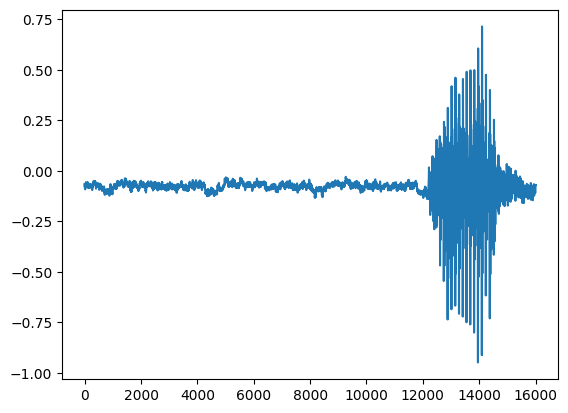

In [12]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [12]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))  # Warning:  This takes a long time!
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [13]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [14]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [15]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [16]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [17]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [18]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [20]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [21]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [22]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0.0026666666666666666/2 [00:01<13:52, 416.69s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.759201


  3%|▎         | 0.05599999999999999/2 [00:12<07:08, 220.51s/it]  

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.251805


  5%|▌         | 0.10933333333333328/2 [00:24<06:52, 218.04s/it] 

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.806070


  8%|▊         | 0.16266666666666676/2 [00:36<06:52, 224.32s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.322968


 11%|█         | 0.21600000000000033/2 [00:48<06:31, 219.67s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.042068


 13%|█▎        | 0.2693333333333337/2 [01:00<06:29, 224.92s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.020540


 16%|█▌        | 0.3226666666666667/2 [01:12<06:18, 225.89s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.750406


 19%|█▉        | 0.3759999999999997/2 [01:25<06:29, 240.04s/it] 

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.575492


 21%|██▏       | 0.42933333333333273/2 [01:37<05:49, 222.22s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.396857


 24%|██▍       | 0.48266666666666574/2 [01:49<05:49, 230.08s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.347927


 27%|██▋       | 0.5359999999999995/2 [02:01<05:16, 216.24s/it] 

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.473323


 29%|██▉       | 0.5893333333333336/2 [02:13<05:36, 238.31s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.337694


 32%|███▏      | 0.6426666666666677/2 [02:26<05:11, 229.72s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.237604


 35%|███▍      | 0.6960000000000018/2 [02:38<04:56, 227.70s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.124625


 37%|███▋      | 0.749333333333336/2 [02:50<04:37, 222.16s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.208826


 40%|████      | 0.8026666666666701/2 [03:03<04:33, 228.10s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.235157


 43%|████▎     | 0.8560000000000042/2 [03:15<04:17, 224.91s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.988290


 50%|█████     | 1.0000000000000062/2 [04:01<04:32, 272.90s/it]


Test Epoch: 1	Accuracy: 7197/11005 (65%)



 50%|█████     | 1.0026666666666728/2 [04:01<04:10, 250.82s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.170113


 53%|█████▎    | 1.0560000000000047/2 [04:13<03:35, 228.61s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.042425


 55%|█████▌    | 1.1093333333333366/2 [04:25<03:16, 220.17s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.066193


 58%|█████▊    | 1.1626666666666685/2 [04:37<03:08, 224.53s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.009704


 61%|██████    | 1.2160000000000004/2 [04:49<03:02, 232.58s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.965655


 63%|██████▎   | 1.2693333333333323/2 [05:01<02:42, 221.75s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.032834


 66%|██████▌   | 1.3226666666666642/2 [05:12<02:27, 217.11s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 1.023145


 69%|██████▉   | 1.3759999999999961/2 [05:24<02:16, 218.88s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 1.001555


 71%|███████▏  | 1.429333333333328/2 [05:36<02:03, 215.62s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 1.050986


 74%|███████▍  | 1.48266666666666/2 [05:48<01:56, 225.23s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 1.007870


 77%|███████▋  | 1.5359999999999918/2 [05:59<01:38, 213.33s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 1.035082


 79%|███████▉  | 1.5893333333333237/2 [06:10<01:27, 213.73s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.809247


 82%|████████▏ | 1.6426666666666556/2 [06:22<01:18, 218.84s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.846265


 85%|████████▍ | 1.6959999999999875/2 [06:34<01:08, 225.21s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.816448


 87%|████████▋ | 1.7493333333333194/2 [06:45<00:53, 215.27s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 1.004982


 90%|█████████ | 1.8026666666666513/2 [06:57<00:44, 227.52s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.832066


 93%|█████████▎| 1.8559999999999832/2 [07:09<00:31, 221.78s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.947560


100%|█████████▉| 1.9999999999999793/2 [07:41<00:00, 230.78s/it]


Test Epoch: 2	Accuracy: 8012/11005 (73%)



The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [23]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [24]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: three.
